In [1]:
!pip install catboost
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 5.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [ ]:
dataInfl = pd.read_excel('Инфляция и ключевая ставка Банка России_F01_01_2022_T31_12_2023.xlsx')

In [ ]:
data = pd.read_excel('data.xlsx')

In [ ]:
from sklearn.preprocessing import LabelEncoder
def encode_columns(df):
    le = LabelEncoder()
    for column in data.select_dtypes(include=['object']).columns:
        df[column] = le.fit_transform(df[column])
    return df
data = encode_columns(data)
data['Дата бронирования'] = pd.to_datetime(data['Дата бронирования'])
data['year_Дата бронирования'] = data['Дата бронирования'].dt.year.astype('int64')
data['month_Дата бронирования'] = data['Дата бронирования'].dt.month.astype('int64')
data['day_Дата бронирования'] = data['Дата бронирования'].dt.day.astype('int64')
data['hour_Дата бронирования'] = data['Дата бронирования'].dt.hour.astype('int64')
data['day_of_week_Дата бронирования'] = data['Дата бронирования'].dt.dayofweek.astype('int64')
data.drop('Дата бронирования', axis=1, inplace=True)
data['Заезд'] = pd.to_datetime(data['Заезд'])
data['month_Заезд'] = data['Заезд'].dt.month.astype('int64')
data['day_Заезд'] = data['Заезд'].dt.day.astype('int64')
data['hour_Заезд'] = data['Заезд'].dt.hour.astype('int64')
data['day_of_week_Заезд'] = data['Заезд'].dt.dayofweek.astype('int64')
data.drop('Заезд', axis=1, inplace=True)
data['Выезд'] = pd.to_datetime(data['Выезд'])
data['month_Выезд'] = data['Выезд'].dt.month.astype('int64')
data['day_Выезд'] = data['Выезд'].dt.day.astype('int64')
data['hour_Выезд'] = data['Выезд'].dt.hour.astype('int64')
data['day_of_week_Выезд'] = data['Выезд'].dt.dayofweek.astype('int64')
data.drop('Выезд', axis=1, inplace=True)
def определить_сезон(month):
    if month == 12 or month < 3:
        return 1
    elif 2 < month < 6:
        return 2
    elif 5 < month < 9:
        return 3
    elif 8 < month < 12:
        return 4

data['Сезон'] = data['month_Заезд'].apply(определить_сезон)

data = data.merge(dataInfl, left_on=['month_Дата бронирования', 'year_Дата бронирования'],
                  right_on=['Месяц', 'Год'], how='left')

data.drop(['Год', 'Месяц', 'year_Дата бронирования'], axis=1, inplace=True)
y = data['Target']
data = data.drop('Target', axis=1)
scaler = StandardScaler()
data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.7, random_state=42)

In [ ]:
data.head()

In [ ]:
Y = data['Отмена']
X = data.drop(columns=["Отмена"])

In [ ]:
data1 = X["Дата бронирования"]
data2 = X["Заезд"]
data3 = X["Выезд"]
X.drop(columns=["Дата бронирования", "Заезд", "Выезд"], inplace=True)
X['data1_day_week'] = data1.dt.day_of_week
X['data2_day_week'] = data2.dt.day_of_week
X['data3_day_week'] = data3.dt.day_of_week

X['data1_day_year'] = data1.dt.day_of_year
X['data2_day_year'] = data2.dt.day_of_year
X['data3_day_year'] = data3.dt.day_of_year

X['data1_m'] = data1.dt.month
X['data2_m'] = data2.dt.month
X['data3_m'] = data3.dt.month


In [ ]:
from sklearn.model_selection import KFold
from catboost import Pool, cv, CatBoostClassifier
from sklearn.metrics import roc_auc_score
pool = Pool(X, Y, cat_features=["Источник", "Категория номера", "Способ оплаты"])
params = {
    "loss_function": "Logloss",
    'eval_metric': 'AUC',
    "max_depth":5,
    "n_estimators":1500
}
cv_ = cv(pool, params, fold_count=4, plot = True, verbose = 0)

In [ ]:
import optuna
from catboost import CatBoostClassifier
cat_features = ['Способ оплаты', 'Источник', 'Категория номера']

def objective(trial):
    # Подбор гиперпараметров
    iterations = trial.suggest_int('iterations', 500, 1500)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.4)
    depth = trial.suggest_int('depth', 4, 12)
    l2_leaf_reg = trial.suggest_int('l2_leaf_reg', 3, 15)
    random_strength = trial.suggest_int('random_strength', 1, 10)

    model = CatBoostClassifier(iterations=iterations,
                               learning_rate=learning_rate,
                               depth=depth,
                               random_seed=42,
                               cat_features=cat_features,
                               l2_leaf_reg = l2_leaf_reg,
                               random_strength=random_strength,
                               verbose=0)

    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)

    # Оценка модели
    return roc_auc_score(y_test, y_pred_proba[:, 1])

# Запуск оптимизации
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Вывод наилучших гиперпараметров
print("Best hyperparameters: ", study.best_params)
print("Best AUC: ", study.best_value)

In [ ]:
cv_['test-AUC-mean'].max()

In [ ]:
model = CatBoostClassifier(**params)
model.fit(X, Y, cat_features=["Источник", "Категория номера", "Способ оплаты"])
pred = model.predict_proba(X)[:, 1]
roc_auc_score(Y, pred)

In [3]:
import shap
shap.initjs()

# Create a TreeExplainer object for the 'model' (assumes 'model' is a tree-based model like a Random Forest or XGBoost)
ex = shap.TreeExplainer(model)

# Calculate SHAP values for the 'X_test' data using the TreeExplainer
shap_values = ex.shap_values(X)

# Generate a summary plot to visualize the impact of features on model predictions
shap.summary_plot(shap_values, X)

In [ ]:
from xgboost import XGBClassifier
model = XGBClassifier(
    learning_rate=0.006950720574050374,
    n_estimators=792,
    max_depth=12,
    min_child_weight=10,
    subsample=0.5596463004848191,
    colsample_bytree=0.612794945187458,
    random_state=42)
model.fit(X_train, y_train)

# Предсказание
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)
print(classification_report(y_test, y_pred))
print(f'ROC-AUC: {roc_auc_score(y_test, y_pred_proba[:, 1])}')

              precision    recall  f1-score   support

           0       0.89      1.00      0.94     14710
           1       0.97      0.51      0.67      3612

    accuracy                           0.90     18322
   macro avg       0.93      0.75      0.81     18322
weighted avg       0.91      0.90      0.89     18322

ROC-AUC: 0.8367116598271642


In [ ]:
from xgboost import XGBClassifier
import optuna
def objective(trial):
    # Подбор гиперпараметров
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 0.4)
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 3, 12)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5, 1.0)

    # Создание и обучение модели
    model = XGBClassifier(
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss'  # Для оценки во время обучения
    )

    model.fit(X_train, y_train)

    # Прогнозирование вероятностей на валидационной выборке
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Вероятности для положительного класса

    # Оценка качества модели по ROC-AUC
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    return roc_auc

# Запуск оптимизации
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Вывод лучших гиперпараметров
print('Best trial:')
trial = study.best_trial
print(f'  Value: {trial.value}')
print('  Params:')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

[I 2024-09-21 10:03:13,089] A new study created in memory with name: no-name-57ec561a-3bae-4f53-9177-d8ced9f2c27c
<ipython-input-13-ff88f317f9c1>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 0.4)
<ipython-input-13-ff88f317f9c1>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
<ipython-input-13-ff88f317f9c1>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5, 1.0

Best trial:
  Value: 0.8363743805112198
  Params:
    learning_rate: 0.0035871649830831803
    n_estimators: 882
    max_depth: 8
    min_child_weight: 10
    subsample: 0.8925740442079494
    colsample_bytree: 0.9166434738967718


In [ ]:
import lightgbm as lgb
model = lgb.LGBMClassifier(
    learning_rate=0.010875824477960197,
    n_estimators=498,
    max_depth=7,
    num_leaves=20,
    min_child_samples=15,
    subsample=0.6787885629620536,
    colsample_bytree=0.8882096601721153,
    random_state=42)
model.fit(X_train, y_train)

# Предсказание
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)
print(classification_report(y_test, y_pred))
print(f'ROC-AUC: {roc_auc_score(y_test, y_pred_proba[:, 1])}')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000909 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670


In [ ]:
# Предсказание
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)
print(classification_report(y_test, y_pred))
print(f'ROC-AUC: {roc_auc_score(y_test, y_pred_proba[:, 1])}')

              precision    recall  f1-score   support

           0       0.89      1.00      0.94     14710
           1       0.97      0.51      0.67      3612

    accuracy                           0.90     18322
   macro avg       0.93      0.75      0.81     18322
weighted avg       0.91      0.90      0.89     18322

ROC-AUC: 0.8376104031956323


In [ ]:
import lightgbm as lgb
def objective(trial):
    # Подбор гиперпараметров
    learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 3, 12)
    num_leaves = trial.suggest_int('num_leaves', 20, 50)
    min_child_samples = trial.suggest_int('min_child_samples', 1, 50)
    subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.6, 1.0)

    # Создание и обучение модели
    model = lgb.LGBMClassifier(
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        max_depth=max_depth,
        num_leaves=num_leaves,
        min_child_samples=min_child_samples,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        random_state=42
    )

    model.fit(X_train, y_train)

    # Прогнозирование вероятностей на валидационной выборке
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Вероятности для положительного класса

    # Оценка качества модели по ROC-AUC
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    return roc_auc

# Запуск оптимизации
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Вывод лучших гиперпараметров
print('Best trial:')
trial = study.best_trial
print(f'  Value: {trial.value}')
print('  Params:')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
[I 2024-09-21 10:09:27,182] A new study created in memory with name: no-name-e0751a40-6477-43ad-9a17-a829ed3246bc
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_unifor

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001494 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-09-21 10:09:29,574] Trial 0 finished with value: 0.806609389127412 and parameters: {'learning_rate': 0.2143766439291514, 'n_estimators': 823, 'max_depth': 6, 'num_leaves': 20, 'min_child_samples': 48, 'subsample': 0.7979615971519786, 'colsample_bytree': 0.8547300469092378}. Best is trial 0 with value: 0.806609389127412.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000882 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-09-21 10:09:33,047] Trial 1 finished with value: 0.8114513013875495 and parameters: {'learning_rate': 0.27015971351580603, 'n_estimators': 753, 'max_depth': 12, 'num_leaves': 49, 'min_child_samples': 42, 'subsample': 0.6175962420667447, 'colsample_bytree': 0.8891274841774387}. Best is trial 1 with value: 0.8114513013875495.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has bee

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000759 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-09-21 10:09:35,399] Trial 2 finished with value: 0.8070399164203015 and parameters: {'learning_rate': 0.26328256009017337, 'n_estimators': 608, 'max_depth': 10, 'num_leaves': 49, 'min_child_samples': 19, 'subsample': 0.9844895230982615, 'colsample_bytree': 0.8214599711100594}. Best is trial 1 with value: 0.8114513013875495.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has bee

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2024-09-21 10:09:37,771] Trial 3 finished with value: 0.8036584844837024 and parameters: {'learning_rate': 0.2767541914001854, 'n_estimators': 611, 'max_depth': 5, 'num_leaves': 32, 'min_child_samples': 25, 'subsample': 0.8898801665537981, 'colsample_bytree': 0.6039499178821179}. Best is trial 1 with value: 0.8114513013875495.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has been 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001391 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-09-21 10:09:39,110] Trial 4 finished with value: 0.8060481132835409 and parameters: {'learning_rate': 0.39538429684200455, 'n_estimators': 380, 'max_depth': 7, 'num_leaves': 23, 'min_child_samples': 19, 'subsample': 0.8467978448124395, 'colsample_bytree': 0.8913965648861567}. Best is trial 1 with value: 0.8114513013875495.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has been

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001376 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670


[I 2024-09-21 10:09:40,657] Trial 5 finished with value: 0.83404353868403 and parameters: {'learning_rate': 0.012022442186663523, 'n_estimators': 276, 'max_depth': 11, 'num_leaves': 37, 'min_child_samples': 24, 'subsample': 0.7926673866185531, 'colsample_bytree': 0.9341145842100442}. Best is trial 5 with value: 0.83404353868403.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has been d

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002055 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 832
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2024-09-21 10:09:41,831] Trial 6 finished with value: 0.831445224130156 and parameters: {'learning_rate': 0.018480714037941246, 'n_estimators': 272, 'max_depth': 4, 'num_leaves': 42, 'min_child_samples': 2, 'subsample': 0.8785328874913556, 'colsample_bytree': 0.6396171735611969}. Best is trial 5 with value: 0.83404353868403.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2024-09-21 10:09:43,025] Trial 7 finished with value: 0.8328982325701849 and parameters: {'learning_rate': 0.0696761855987613, 'n_estimators': 285, 'max_depth': 3, 'num_leaves': 22, 'min_child_samples': 15, 'subsample': 0.7504124060518926, 'colsample_bytree': 0.7286176670990734}. Best is trial 5 with value: 0.83404353868403.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has been de

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000881 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-09-21 10:09:45,312] Trial 8 finished with value: 0.8288116486852121 and parameters: {'learning_rate': 0.02416806552894929, 'n_estimators': 881, 'max_depth': 11, 'num_leaves': 20, 'min_child_samples': 33, 'subsample': 0.9657814990572263, 'colsample_bytree': 0.8070531196786107}. Best is trial 5 with value: 0.83404353868403.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has been 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000974 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-09-21 10:09:46,308] Trial 9 finished with value: 0.827230178429331 and parameters: {'learning_rate': 0.04797567400486022, 'n_estimators': 384, 'max_depth': 11, 'num_leaves': 21, 'min_child_samples': 50, 'subsample': 0.7699390953195705, 'colsample_bytree': 0.9576240449485203}. Best is trial 5 with value: 0.83404353868403.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has been d

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001010 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 828
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670


[I 2024-09-21 10:09:46,797] Trial 10 finished with value: 0.831653589929482 and parameters: {'learning_rate': 0.010423954765482982, 'n_estimators': 140, 'max_depth': 9, 'num_leaves': 34, 'min_child_samples': 6, 'subsample': 0.6634479643374505, 'colsample_bytree': 0.9986167010678605}. Best is trial 5 with value: 0.83404353868403.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has been d

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000839 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-09-21 10:09:47,136] Trial 11 finished with value: 0.8293549976549202 and parameters: {'learning_rate': 0.09186441759751873, 'n_estimators': 108, 'max_depth': 3, 'num_leaves': 28, 'min_child_samples': 12, 'subsample': 0.7093283369454113, 'colsample_bytree': 0.7412975479842949}. Best is trial 5 with value: 0.83404353868403.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has been 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001219 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-09-21 10:09:48,631] Trial 12 finished with value: 0.81653178693576 and parameters: {'learning_rate': 0.07538534337616618, 'n_estimators': 401, 'max_depth': 8, 'num_leaves': 41, 'min_child_samples': 33, 'subsample': 0.735209780718226, 'colsample_bytree': 0.7072435122531473}. Best is trial 5 with value: 0.83404353868403.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has been dep

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000840 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-09-21 10:09:49,546] Trial 13 finished with value: 0.8284661258302825 and parameters: {'learning_rate': 0.04359107545429656, 'n_estimators': 259, 'max_depth': 8, 'num_leaves': 39, 'min_child_samples': 14, 'subsample': 0.7199181135554327, 'colsample_bytree': 0.7434222718756114}. Best is trial 5 with value: 0.83404353868403.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has been 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001205 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-09-21 10:09:51,126] Trial 14 finished with value: 0.8263278402755977 and parameters: {'learning_rate': 0.11741120109467496, 'n_estimators': 501, 'max_depth': 3, 'num_leaves': 27, 'min_child_samples': 28, 'subsample': 0.8350481710997382, 'colsample_bytree': 0.7107339997206447}. Best is trial 5 with value: 0.83404353868403.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has been 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001529 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-09-21 10:09:52,327] Trial 15 finished with value: 0.8329272261131224 and parameters: {'learning_rate': 0.026821190622109192, 'n_estimators': 246, 'max_depth': 6, 'num_leaves': 38, 'min_child_samples': 21, 'subsample': 0.7612358806674385, 'colsample_bytree': 0.938655491605228}. Best is trial 5 with value: 0.83404353868403.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has been 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001420 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-09-21 10:09:56,355] Trial 16 finished with value: 0.8260183123254836 and parameters: {'learning_rate': 0.013903380089768748, 'n_estimators': 1000, 'max_depth': 6, 'num_leaves': 37, 'min_child_samples': 26, 'subsample': 0.6726566309264519, 'colsample_bytree': 0.9379829797278857}. Best is trial 5 with value: 0.83404353868403.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has bee

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000958 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-09-21 10:09:57,258] Trial 17 finished with value: 0.831393391467222 and parameters: {'learning_rate': 0.03044497581143552, 'n_estimators': 225, 'max_depth': 7, 'num_leaves': 45, 'min_child_samples': 33, 'subsample': 0.9281438706956987, 'colsample_bytree': 0.9959149522427339}. Best is trial 5 with value: 0.83404353868403.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has been d

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000895 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-09-21 10:09:58,932] Trial 18 finished with value: 0.8326974892212904 and parameters: {'learning_rate': 0.017367219978259657, 'n_estimators': 481, 'max_depth': 9, 'num_leaves': 32, 'min_child_samples': 39, 'subsample': 0.8018945941495166, 'colsample_bytree': 0.9199462748151443}. Best is trial 5 with value: 0.83404353868403.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has been

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000903 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670


[I 2024-09-21 10:09:59,642] Trial 19 finished with value: 0.831787622721452 and parameters: {'learning_rate': 0.03165461926723687, 'n_estimators': 179, 'max_depth': 12, 'num_leaves': 44, 'min_child_samples': 22, 'subsample': 0.7980546090284095, 'colsample_bytree': 0.8568595541695754}. Best is trial 5 with value: 0.83404353868403.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has been 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001039 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 828
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-09-21 10:10:00,642] Trial 20 finished with value: 0.834065399119033 and parameters: {'learning_rate': 0.012375600294493357, 'n_estimators': 343, 'max_depth': 5, 'num_leaves': 29, 'min_child_samples': 7, 'subsample': 0.6022716918599803, 'colsample_bytree': 0.9652534647610309}. Best is trial 20 with value: 0.834065399119033.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has been

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001013 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 828
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-09-21 10:10:01,783] Trial 21 finished with value: 0.8327942096478766 and parameters: {'learning_rate': 0.010844327277830329, 'n_estimators': 332, 'max_depth': 5, 'num_leaves': 36, 'min_child_samples': 8, 'subsample': 0.6212661991052757, 'colsample_bytree': 0.9657785911318543}. Best is trial 20 with value: 0.834065399119033.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has bee

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001059 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 832
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-09-21 10:10:03,178] Trial 22 finished with value: 0.8352570139718576 and parameters: {'learning_rate': 0.016601321070625095, 'n_estimators': 446, 'max_depth': 5, 'num_leaves': 29, 'min_child_samples': 1, 'subsample': 0.6766006340808665, 'colsample_bytree': 0.9146006658444585}. Best is trial 22 with value: 0.8352570139718576.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has be

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001563 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 832
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-09-21 10:10:05,177] Trial 23 finished with value: 0.8348826293200473 and parameters: {'learning_rate': 0.016157510682616553, 'n_estimators': 466, 'max_depth': 5, 'num_leaves': 27, 'min_child_samples': 4, 'subsample': 0.6606938549826031, 'colsample_bytree': 0.9091382184526865}. Best is trial 22 with value: 0.8352570139718576.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has be

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001432 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 832
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-09-21 10:10:06,996] Trial 24 finished with value: 0.8343243554041857 and parameters: {'learning_rate': 0.017574429194041605, 'n_estimators': 471, 'max_depth': 5, 'num_leaves': 27, 'min_child_samples': 2, 'subsample': 0.6001247397962742, 'colsample_bytree': 0.8955575821425933}. Best is trial 22 with value: 0.8352570139718576.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has be

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001241 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 832
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-09-21 10:10:08,634] Trial 25 finished with value: 0.833519848108089 and parameters: {'learning_rate': 0.019187209925385376, 'n_estimators': 576, 'max_depth': 4, 'num_leaves': 26, 'min_child_samples': 1, 'subsample': 0.6566370449444306, 'colsample_bytree': 0.892829443521766}. Best is trial 22 with value: 0.8352570139718576.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has been

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001025 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 832
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-09-21 10:10:10,000] Trial 26 finished with value: 0.830454145596708 and parameters: {'learning_rate': 0.04020303281682756, 'n_estimators': 490, 'max_depth': 4, 'num_leaves': 25, 'min_child_samples': 3, 'subsample': 0.6925648678180752, 'colsample_bytree': 0.8492957506595897}. Best is trial 22 with value: 0.8352570139718576.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has been

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000923 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 828
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-09-21 10:10:12,379] Trial 27 finished with value: 0.8316763914077481 and parameters: {'learning_rate': 0.01578553748297768, 'n_estimators': 727, 'max_depth': 5, 'num_leaves': 30, 'min_child_samples': 10, 'subsample': 0.6387217922721945, 'colsample_bytree': 0.7887160865371633}. Best is trial 22 with value: 0.8352570139718576.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has be

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000976 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 828
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670


[I 2024-09-21 10:10:14,225] Trial 28 finished with value: 0.8307687551804431 and parameters: {'learning_rate': 0.02238094394681469, 'n_estimators': 666, 'max_depth': 6, 'num_leaves': 24, 'min_child_samples': 5, 'subsample': 0.6397664434847016, 'colsample_bytree': 0.9007757839828894}. Best is trial 22 with value: 0.8352570139718576.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has bee

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 828
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2024-09-21 10:10:15,549] Trial 29 finished with value: 0.8132195404998671 and parameters: {'learning_rate': 0.12861386891388946, 'n_estimators': 426, 'max_depth': 7, 'num_leaves': 32, 'min_child_samples': 10, 'subsample': 0.6924486879609734, 'colsample_bytree': 0.84181701355035}. Best is trial 22 with value: 0.8352570139718576.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has been

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001014 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 832
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-09-21 10:10:17,148] Trial 30 finished with value: 0.8325033990482665 and parameters: {'learning_rate': 0.03622229029823502, 'n_estimators': 519, 'max_depth': 4, 'num_leaves': 29, 'min_child_samples': 1, 'subsample': 0.6403103388075798, 'colsample_bytree': 0.7786614311410579}. Best is trial 22 with value: 0.8352570139718576.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has bee

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001392 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 828
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-09-21 10:10:19,067] Trial 31 finished with value: 0.8347089033232378 and parameters: {'learning_rate': 0.013776005682262308, 'n_estimators': 428, 'max_depth': 5, 'num_leaves': 30, 'min_child_samples': 6, 'subsample': 0.6072389036953695, 'colsample_bytree': 0.9685187127516817}. Best is trial 22 with value: 0.8352570139718576.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has be

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002589 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 828
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-09-21 10:10:20,928] Trial 32 finished with value: 0.8339764046576371 and parameters: {'learning_rate': 0.014825609596080935, 'n_estimators': 448, 'max_depth': 5, 'num_leaves': 34, 'min_child_samples': 5, 'subsample': 0.612172241018815, 'colsample_bytree': 0.8718405114130954}. Best is trial 22 with value: 0.8352570139718576.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has bee

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000947 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-09-21 10:10:22,621] Trial 33 finished with value: 0.830258935582201 and parameters: {'learning_rate': 0.02108145165211532, 'n_estimators': 568, 'max_depth': 6, 'num_leaves': 26, 'min_child_samples': 15, 'subsample': 0.6797499758152087, 'colsample_bytree': 0.9677485839193576}. Best is trial 22 with value: 0.8352570139718576.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has bee

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001037 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 832
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-09-21 10:10:24,473] Trial 34 finished with value: 0.8335574051447212 and parameters: {'learning_rate': 0.01400063740542888, 'n_estimators': 660, 'max_depth': 4, 'num_leaves': 31, 'min_child_samples': 4, 'subsample': 0.6278329544687553, 'colsample_bytree': 0.9138323657952728}. Best is trial 22 with value: 0.8352570139718576.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has bee

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001416 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 828
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-09-21 10:10:25,853] Trial 35 finished with value: 0.8262935486590887 and parameters: {'learning_rate': 0.05023216238237755, 'n_estimators': 446, 'max_depth': 5, 'num_leaves': 27, 'min_child_samples': 10, 'subsample': 0.6070830586560574, 'colsample_bytree': 0.8773282817597462}. Best is trial 22 with value: 0.8352570139718576.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has be

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000974 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 828
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670


[I 2024-09-21 10:10:26,777] Trial 36 finished with value: 0.83439482072373 and parameters: {'learning_rate': 0.025537144061907116, 'n_estimators': 331, 'max_depth': 7, 'num_leaves': 24, 'min_child_samples': 8, 'subsample': 0.6575695023033613, 'colsample_bytree': 0.9148621463711701}. Best is trial 22 with value: 0.8352570139718576.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has been

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000897 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-09-21 10:10:27,673] Trial 37 finished with value: 0.833544108203413 and parameters: {'learning_rate': 0.025977356446810655, 'n_estimators': 318, 'max_depth': 7, 'num_leaves': 24, 'min_child_samples': 18, 'subsample': 0.7100171045322703, 'colsample_bytree': 0.8347198159367161}. Best is trial 22 with value: 0.8352570139718576.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has be

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000967 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 828
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670


[I 2024-09-21 10:10:28,650] Trial 38 finished with value: 0.8354481492690352 and parameters: {'learning_rate': 0.012853638402119812, 'n_estimators': 352, 'max_depth': 6, 'num_leaves': 23, 'min_child_samples': 9, 'subsample': 0.6558652793880317, 'colsample_bytree': 0.9216709643682025}. Best is trial 38 with value: 0.8354481492690352.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has be

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001044 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670


[I 2024-09-21 10:10:30,001] Trial 39 finished with value: 0.8360712987074583 and parameters: {'learning_rate': 0.010185314560547776, 'n_estimators': 527, 'max_depth': 6, 'num_leaves': 22, 'min_child_samples': 12, 'subsample': 0.6882119592930361, 'colsample_bytree': 0.9791155573693646}. Best is trial 39 with value: 0.8360712987074583.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has b

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000962 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-09-21 10:10:32,392] Trial 40 finished with value: 0.8367473441877027 and parameters: {'learning_rate': 0.010315627770611797, 'n_estimators': 634, 'max_depth': 6, 'num_leaves': 22, 'min_child_samples': 13, 'subsample': 0.734319810894062, 'colsample_bytree': 0.9837832641033113}. Best is trial 40 with value: 0.8367473441877027.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has be

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001391 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670


[I 2024-09-21 10:10:34,494] Trial 41 finished with value: 0.8365480876871642 and parameters: {'learning_rate': 0.011070522231943802, 'n_estimators': 630, 'max_depth': 6, 'num_leaves': 22, 'min_child_samples': 13, 'subsample': 0.6901956390370327, 'colsample_bytree': 0.9903280528946281}. Best is trial 40 with value: 0.8367473441877027.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has b

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000910 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-09-21 10:10:36,099] Trial 42 finished with value: 0.8364323487762297 and parameters: {'learning_rate': 0.010122680296776647, 'n_estimators': 612, 'max_depth': 6, 'num_leaves': 20, 'min_child_samples': 17, 'subsample': 0.7346370023458658, 'colsample_bytree': 0.9860868508682307}. Best is trial 40 with value: 0.8367473441877027.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has b

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000908 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-09-21 10:10:38,246] Trial 43 finished with value: 0.835413020124022 and parameters: {'learning_rate': 0.010385696211753528, 'n_estimators': 790, 'max_depth': 6, 'num_leaves': 20, 'min_child_samples': 17, 'subsample': 0.736056647310859, 'colsample_bytree': 0.9955677193935415}. Best is trial 40 with value: 0.8367473441877027.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has bee

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000945 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670


[I 2024-09-21 10:10:39,949] Trial 44 finished with value: 0.8339885723470297 and parameters: {'learning_rate': 0.01169090841489579, 'n_estimators': 648, 'max_depth': 8, 'num_leaves': 22, 'min_child_samples': 13, 'subsample': 0.7290928392194694, 'colsample_bytree': 0.9818352493399499}. Best is trial 40 with value: 0.8367473441877027.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has be

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000917 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-09-21 10:10:41,995] Trial 45 finished with value: 0.8356201813879711 and parameters: {'learning_rate': 0.012345534485938387, 'n_estimators': 717, 'max_depth': 6, 'num_leaves': 22, 'min_child_samples': 15, 'subsample': 0.7682152337565642, 'colsample_bytree': 0.9482611978173536}. Best is trial 40 with value: 0.8367473441877027.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has b

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000945 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-09-21 10:10:44,158] Trial 46 finished with value: 0.8352580397090144 and parameters: {'learning_rate': 0.01071443225427802, 'n_estimators': 724, 'max_depth': 7, 'num_leaves': 21, 'min_child_samples': 17, 'subsample': 0.7826604659205004, 'colsample_bytree': 0.9472099132212795}. Best is trial 40 with value: 0.8367473441877027.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has be

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001415 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670


[I 2024-09-21 10:10:46,601] Trial 47 finished with value: 0.8349256444076057 and parameters: {'learning_rate': 0.012190370048590539, 'n_estimators': 610, 'max_depth': 6, 'num_leaves': 22, 'min_child_samples': 12, 'subsample': 0.7516767294047411, 'colsample_bytree': 0.9879944251684761}. Best is trial 40 with value: 0.8367473441877027.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has b

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001330 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670


[I 2024-09-21 10:10:48,991] Trial 48 finished with value: 0.8362721738024095 and parameters: {'learning_rate': 0.010021597678135099, 'n_estimators': 831, 'max_depth': 8, 'num_leaves': 20, 'min_child_samples': 21, 'subsample': 0.8157267503675826, 'colsample_bytree': 0.9506389802282378}. Best is trial 40 with value: 0.8367473441877027.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has b

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000974 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670


[I 2024-09-21 10:10:51,347] Trial 49 finished with value: 0.8356682122361221 and parameters: {'learning_rate': 0.010560150238425076, 'n_estimators': 877, 'max_depth': 9, 'num_leaves': 20, 'min_child_samples': 21, 'subsample': 0.8172447143028234, 'colsample_bytree': 0.9795151461169573}. Best is trial 40 with value: 0.8367473441877027.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has b

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001847 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-09-21 10:10:52,688] Trial 50 finished with value: 0.8099146530222922 and parameters: {'learning_rate': 0.20451944562374966, 'n_estimators': 542, 'max_depth': 8, 'num_leaves': 20, 'min_child_samples': 29, 'subsample': 0.8544222393054536, 'colsample_bytree': 0.6153296976035476}. Best is trial 40 with value: 0.8367473441877027.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has be

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001323 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670


[I 2024-09-21 10:10:55,209] Trial 51 finished with value: 0.8332656158601173 and parameters: {'learning_rate': 0.010347552228976495, 'n_estimators': 936, 'max_depth': 9, 'num_leaves': 20, 'min_child_samples': 22, 'subsample': 0.8169354136729519, 'colsample_bytree': 0.9779607406435789}. Best is trial 40 with value: 0.8367473441877027.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has b

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000919 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670


[I 2024-09-21 10:10:57,883] Trial 52 finished with value: 0.8332062830823759 and parameters: {'learning_rate': 0.010208268818211436, 'n_estimators': 858, 'max_depth': 9, 'num_leaves': 23, 'min_child_samples': 20, 'subsample': 0.8255673591626558, 'colsample_bytree': 0.9991893369467167}. Best is trial 40 with value: 0.8367473441877027.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has b

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001429 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670


[I 2024-09-21 10:11:00,854] Trial 53 finished with value: 0.8298550304032258 and parameters: {'learning_rate': 0.0197654511740824, 'n_estimators': 783, 'max_depth': 10, 'num_leaves': 21, 'min_child_samples': 23, 'subsample': 0.8578075933871633, 'colsample_bytree': 0.9519923234817482}. Best is trial 40 with value: 0.8367473441877027.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has be

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000939 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670


[I 2024-09-21 10:11:03,299] Trial 54 finished with value: 0.830209756661269 and parameters: {'learning_rate': 0.014312747409142871, 'n_estimators': 899, 'max_depth': 10, 'num_leaves': 21, 'min_child_samples': 25, 'subsample': 0.8810522163919959, 'colsample_bytree': 0.9824914929826338}. Best is trial 40 with value: 0.8367473441877027.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has b

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000962 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-09-21 10:11:05,838] Trial 55 finished with value: 0.8327253629227449 and parameters: {'learning_rate': 0.01186118317104668, 'n_estimators': 850, 'max_depth': 8, 'num_leaves': 25, 'min_child_samples': 19, 'subsample': 0.9089050016430446, 'colsample_bytree': 0.9390064528842893}. Best is trial 40 with value: 0.8367473441877027.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has be

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000924 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-09-21 10:11:08,675] Trial 56 finished with value: 0.8303203386551212 and parameters: {'learning_rate': 0.01538641203427173, 'n_estimators': 967, 'max_depth': 7, 'num_leaves': 23, 'min_child_samples': 16, 'subsample': 0.781971514031781, 'colsample_bytree': 0.9723184345033159}. Best is trial 40 with value: 0.8367473441877027.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has bee

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000918 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670


[I 2024-09-21 10:11:10,749] Trial 57 finished with value: 0.8055214490108883 and parameters: {'learning_rate': 0.3896448993028399, 'n_estimators': 812, 'max_depth': 8, 'num_leaves': 20, 'min_child_samples': 13, 'subsample': 0.8102949440119939, 'colsample_bytree': 0.9316231081528034}. Best is trial 40 with value: 0.8367473441877027.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has bee

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001392 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-09-21 10:11:15,015] Trial 58 finished with value: 0.8284358148267765 and parameters: {'learning_rate': 0.012995543323591364, 'n_estimators': 700, 'max_depth': 9, 'num_leaves': 50, 'min_child_samples': 20, 'subsample': 0.69919236249435, 'colsample_bytree': 0.9566072765005466}. Best is trial 40 with value: 0.8367473441877027.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has bee

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000932 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670


[I 2024-09-21 10:11:16,713] Trial 59 finished with value: 0.8345195936499905 and parameters: {'learning_rate': 0.010258694466596928, 'n_estimators': 632, 'max_depth': 10, 'num_leaves': 22, 'min_child_samples': 27, 'subsample': 0.7526054643659005, 'colsample_bytree': 0.9825808056876484}. Best is trial 40 with value: 0.8367473441877027.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000914 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670


[I 2024-09-21 10:11:18,665] Trial 60 finished with value: 0.832126746482192 and parameters: {'learning_rate': 0.01792780305761747, 'n_estimators': 688, 'max_depth': 7, 'num_leaves': 25, 'min_child_samples': 12, 'subsample': 0.7173615983619938, 'colsample_bytree': 0.9313574945595374}. Best is trial 40 with value: 0.8367473441877027.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has bee

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000898 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-09-21 10:11:20,735] Trial 61 finished with value: 0.8345957334604118 and parameters: {'learning_rate': 0.011565214310172097, 'n_estimators': 744, 'max_depth': 6, 'num_leaves': 22, 'min_child_samples': 15, 'subsample': 0.7623852402916642, 'colsample_bytree': 0.9540049552657363}. Best is trial 40 with value: 0.8367473441877027.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has b

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000908 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-09-21 10:11:22,317] Trial 62 finished with value: 0.8362931214254471 and parameters: {'learning_rate': 0.012500557154901492, 'n_estimators': 591, 'max_depth': 6, 'num_leaves': 21, 'min_child_samples': 18, 'subsample': 0.7777927410653717, 'colsample_bytree': 0.9473135195550708}. Best is trial 40 with value: 0.8367473441877027.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has b

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000948 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-09-21 10:11:23,951] Trial 63 finished with value: 0.8343745882935724 and parameters: {'learning_rate': 0.010081485785023978, 'n_estimators': 608, 'max_depth': 6, 'num_leaves': 21, 'min_child_samples': 30, 'subsample': 0.8383241661109437, 'colsample_bytree': 0.9982576580777394}. Best is trial 40 with value: 0.8367473441877027.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has b

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000912 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-09-21 10:11:26,255] Trial 64 finished with value: 0.835715019728031 and parameters: {'learning_rate': 0.013535173446788179, 'n_estimators': 577, 'max_depth': 7, 'num_leaves': 23, 'min_child_samples': 18, 'subsample': 0.7393815179638699, 'colsample_bytree': 0.9650029090947578}. Best is trial 40 with value: 0.8367473441877027.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has be

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001347 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-09-21 10:11:28,468] Trial 65 finished with value: 0.8331289010948474 and parameters: {'learning_rate': 0.01573429647180227, 'n_estimators': 543, 'max_depth': 7, 'num_leaves': 23, 'min_child_samples': 43, 'subsample': 0.7425235054763544, 'colsample_bytree': 0.9569800913539166}. Best is trial 40 with value: 0.8367473441877027.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has be

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001968 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2024-09-21 10:11:30,638] Trial 66 finished with value: 0.8312515103744373 and parameters: {'learning_rate': 0.01367371547438503, 'n_estimators': 572, 'max_depth': 6, 'num_leaves': 47, 'min_child_samples': 17, 'subsample': 0.786760375651838, 'colsample_bytree': 0.6561939756576884}. Best is trial 40 with value: 0.8367473441877027.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has bee

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000930 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-09-21 10:11:32,026] Trial 67 finished with value: 0.8323087724805824 and parameters: {'learning_rate': 0.022320191189672628, 'n_estimators': 513, 'max_depth': 7, 'num_leaves': 24, 'min_child_samples': 11, 'subsample': 0.7036492485520222, 'colsample_bytree': 0.9664890902564198}. Best is trial 40 with value: 0.8367473441877027.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has b

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000917 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-09-21 10:11:33,842] Trial 68 finished with value: 0.8331642372693785 and parameters: {'learning_rate': 0.017598773859511845, 'n_estimators': 594, 'max_depth': 6, 'num_leaves': 26, 'min_child_samples': 24, 'subsample': 0.7310653188030712, 'colsample_bytree': 0.9400152916620549}. Best is trial 40 with value: 0.8367473441877027.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has b

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000886 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670


[I 2024-09-21 10:11:35,531] Trial 69 finished with value: 0.8346900354058118 and parameters: {'learning_rate': 0.011675301263753393, 'n_estimators': 639, 'max_depth': 8, 'num_leaves': 21, 'min_child_samples': 19, 'subsample': 0.6857095080611701, 'colsample_bytree': 0.9255378816047181}. Best is trial 40 with value: 0.8367473441877027.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has b

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000897 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-09-21 10:11:36,967] Trial 70 finished with value: 0.8339652062428058 and parameters: {'learning_rate': 0.014623465101191025, 'n_estimators': 530, 'max_depth': 7, 'num_leaves': 23, 'min_child_samples': 18, 'subsample': 0.7241983741819761, 'colsample_bytree': 0.9896322087991689}. Best is trial 40 with value: 0.8367473441877027.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has b

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000931 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-09-21 10:11:39,127] Trial 71 finished with value: 0.8351225294791214 and parameters: {'learning_rate': 0.011625243129942854, 'n_estimators': 685, 'max_depth': 6, 'num_leaves': 20, 'min_child_samples': 21, 'subsample': 0.7741089839557104, 'colsample_bytree': 0.9805237559670416}. Best is trial 40 with value: 0.8367473441877027.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has b

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001446 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670


[I 2024-09-21 10:11:42,444] Trial 72 finished with value: 0.8325432898721913 and parameters: {'learning_rate': 0.013098923518491533, 'n_estimators': 910, 'max_depth': 8, 'num_leaves': 21, 'min_child_samples': 14, 'subsample': 0.8048232319815194, 'colsample_bytree': 0.9698468251531163}. Best is trial 40 with value: 0.8367473441877027.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has b

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000914 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670


[I 2024-09-21 10:11:43,931] Trial 73 finished with value: 0.8351863039810647 and parameters: {'learning_rate': 0.01096480495983041, 'n_estimators': 578, 'max_depth': 9, 'num_leaves': 20, 'min_child_samples': 23, 'subsample': 0.7976019204729002, 'colsample_bytree': 0.9644740465103081}. Best is trial 40 with value: 0.8367473441877027.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has be

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000941 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-09-21 10:11:46,092] Trial 74 finished with value: 0.8338120796830265 and parameters: {'learning_rate': 0.013113712960108314, 'n_estimators': 762, 'max_depth': 7, 'num_leaves': 22, 'min_child_samples': 21, 'subsample': 0.7412134261964153, 'colsample_bytree': 0.9451811593702809}. Best is trial 40 with value: 0.8367473441877027.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has b

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000948 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-09-21 10:11:47,741] Trial 75 finished with value: 0.8165130225330928 and parameters: {'learning_rate': 0.08982316594193715, 'n_estimators': 553, 'max_depth': 5, 'num_leaves': 25, 'min_child_samples': 16, 'subsample': 0.8252445137659403, 'colsample_bytree': 0.9860694095873117}. Best is trial 40 with value: 0.8367473441877027.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has be

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001280 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-09-21 10:11:50,461] Trial 76 finished with value: 0.8372504447370461 and parameters: {'learning_rate': 0.010022586913695411, 'n_estimators': 496, 'max_depth': 6, 'num_leaves': 24, 'min_child_samples': 14, 'subsample': 0.7180501088658101, 'colsample_bytree': 0.9021804741656239}. Best is trial 76 with value: 0.8372504447370461.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has b

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001327 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-09-21 10:11:53,965] Trial 77 finished with value: 0.8359723856500689 and parameters: {'learning_rate': 0.015774027964750224, 'n_estimators': 399, 'max_depth': 6, 'num_leaves': 24, 'min_child_samples': 14, 'subsample': 0.7173170164652792, 'colsample_bytree': 0.8199321985824134}. Best is trial 76 with value: 0.8372504447370461.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has b

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-09-21 10:11:57,544] Trial 78 finished with value: 0.8345977096512645 and parameters: {'learning_rate': 0.016520038665526333, 'n_estimators': 408, 'max_depth': 5, 'num_leaves': 24, 'min_child_samples': 13, 'subsample': 0.7117561743229509, 'colsample_bytree': 0.8043055059556634}. Best is trial 76 with value: 0.8372504447370461.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has b

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001246 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-09-21 10:12:00,049] Trial 79 finished with value: 0.8357517674674567 and parameters: {'learning_rate': 0.011341436827355219, 'n_estimators': 506, 'max_depth': 6, 'num_leaves': 25, 'min_child_samples': 11, 'subsample': 0.6818320051634239, 'colsample_bytree': 0.8205854506940515}. Best is trial 76 with value: 0.8372504447370461.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has b

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000887 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-09-21 10:12:01,186] Trial 80 finished with value: 0.8343846386356228 and parameters: {'learning_rate': 0.01937355335074316, 'n_estimators': 370, 'max_depth': 6, 'num_leaves': 28, 'min_child_samples': 14, 'subsample': 0.6708810468242862, 'colsample_bytree': 0.8822571922097441}. Best is trial 76 with value: 0.8372504447370461.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has be

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000895 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-09-21 10:12:02,680] Trial 81 finished with value: 0.8351385648563253 and parameters: {'learning_rate': 0.011296391060055921, 'n_estimators': 515, 'max_depth': 6, 'num_leaves': 24, 'min_child_samples': 11, 'subsample': 0.6891113191051264, 'colsample_bytree': 0.8310936674671542}. Best is trial 76 with value: 0.8372504447370461.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has b

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001014 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 828
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-09-21 10:12:03,959] Trial 82 finished with value: 0.8229708190012444 and parameters: {'learning_rate': 0.0549072506477585, 'n_estimators': 483, 'max_depth': 6, 'num_leaves': 22, 'min_child_samples': 7, 'subsample': 0.7039184104732354, 'colsample_bytree': 0.8190757961695093}. Best is trial 76 with value: 0.8372504447370461.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has been

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000854 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-09-21 10:12:05,798] Trial 83 finished with value: 0.8343769314912977 and parameters: {'learning_rate': 0.010017311195880823, 'n_estimators': 624, 'max_depth': 5, 'num_leaves': 26, 'min_child_samples': 11, 'subsample': 0.7228954175085065, 'colsample_bytree': 0.7604730821357674}. Best is trial 76 with value: 0.8372504447370461.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has b

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001324 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 828
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-09-21 10:12:08,830] Trial 84 finished with value: 0.8338062922669581 and parameters: {'learning_rate': 0.012551645086169355, 'n_estimators': 669, 'max_depth': 6, 'num_leaves': 25, 'min_child_samples': 8, 'subsample': 0.9925631861455978, 'colsample_bytree': 0.7898343216608275}. Best is trial 76 with value: 0.8372504447370461.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has be

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003962 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 828
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2024-09-21 10:12:10,976] Trial 85 finished with value: 0.8345917528474088 and parameters: {'learning_rate': 0.011381672979134954, 'n_estimators': 397, 'max_depth': 5, 'num_leaves': 24, 'min_child_samples': 9, 'subsample': 0.6687294915762658, 'colsample_bytree': 0.8627705474833065}. Best is trial 76 with value: 0.8372504447370461.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has be

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001296 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-09-21 10:12:12,828] Trial 86 finished with value: 0.8364199081842909 and parameters: {'learning_rate': 0.014825144804839853, 'n_estimators': 494, 'max_depth': 6, 'num_leaves': 21, 'min_child_samples': 16, 'subsample': 0.6972948534957581, 'colsample_bytree': 0.905550841063592}. Best is trial 76 with value: 0.8372504447370461.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has be

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001015 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-09-21 10:12:14,089] Trial 87 finished with value: 0.8351873673599521 and parameters: {'learning_rate': 0.015027707412153165, 'n_estimators': 452, 'max_depth': 4, 'num_leaves': 42, 'min_child_samples': 16, 'subsample': 0.7565090953174692, 'colsample_bytree': 0.9077545692545612}. Best is trial 76 with value: 0.8372504447370461.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has b

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000938 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-09-21 10:12:15,260] Trial 88 finished with value: 0.8354618790902446 and parameters: {'learning_rate': 0.0144851172930867, 'n_estimators': 426, 'max_depth': 5, 'num_leaves': 21, 'min_child_samples': 14, 'subsample': 0.6968347673293118, 'colsample_bytree': 0.8988567556464174}. Best is trial 76 with value: 0.8372504447370461.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has bee

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000796 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-09-21 10:12:16,893] Trial 89 finished with value: 0.8341130629603113 and parameters: {'learning_rate': 0.01261606027689235, 'n_estimators': 599, 'max_depth': 6, 'num_leaves': 21, 'min_child_samples': 17, 'subsample': 0.7126778838594723, 'colsample_bytree': 0.6863100403107786}. Best is trial 76 with value: 0.8372504447370461.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has be

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000923 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-09-21 10:12:18,220] Trial 90 finished with value: 0.8305053571710884 and parameters: {'learning_rate': 0.02915748327650729, 'n_estimators': 472, 'max_depth': 6, 'num_leaves': 22, 'min_child_samples': 19, 'subsample': 0.730328856310426, 'colsample_bytree': 0.9906358016192969}. Best is trial 76 with value: 0.8372504447370461.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has bee

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000901 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-09-21 10:12:19,612] Trial 91 finished with value: 0.8362870987485631 and parameters: {'learning_rate': 0.011466857232157625, 'n_estimators': 496, 'max_depth': 6, 'num_leaves': 23, 'min_child_samples': 12, 'subsample': 0.6818210551252333, 'colsample_bytree': 0.8192929781697066}. Best is trial 76 with value: 0.8372504447370461.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has b

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2024-09-21 10:12:21,375] Trial 92 finished with value: 0.8336869209290279 and parameters: {'learning_rate': 0.016331794162371516, 'n_estimators': 555, 'max_depth': 6, 'num_leaves': 23, 'min_child_samples': 13, 'subsample': 0.6508807333147648, 'colsample_bytree': 0.8631191910111262}. Best is trial 76 with value: 0.8372504447370461.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has b

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001534 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670


[I 2024-09-21 10:12:23,306] Trial 93 finished with value: 0.8376104031956323 and parameters: {'learning_rate': 0.010875824477960197, 'n_estimators': 498, 'max_depth': 7, 'num_leaves': 20, 'min_child_samples': 15, 'subsample': 0.6787885629620536, 'colsample_bytree': 0.8882096601721153}. Best is trial 93 with value: 0.8376104031956323.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has b

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001299 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670


[I 2024-09-21 10:12:25,085] Trial 94 finished with value: 0.8373909424962339 and parameters: {'learning_rate': 0.010906415568735787, 'n_estimators': 499, 'max_depth': 7, 'num_leaves': 20, 'min_child_samples': 16, 'subsample': 0.6804498383566212, 'colsample_bytree': 0.9042995805727462}. Best is trial 93 with value: 0.8376104031956323.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has b

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001198 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670


[I 2024-09-21 10:12:26,377] Trial 95 finished with value: 0.8365605847416987 and parameters: {'learning_rate': 0.012367898667033776, 'n_estimators': 491, 'max_depth': 7, 'num_leaves': 20, 'min_child_samples': 16, 'subsample': 0.6763962509513645, 'colsample_bytree': 0.8800388652480464}. Best is trial 93 with value: 0.8376104031956323.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has b

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000898 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670


[I 2024-09-21 10:12:27,586] Trial 96 finished with value: 0.8372005318023689 and parameters: {'learning_rate': 0.01235141589190478, 'n_estimators': 467, 'max_depth': 7, 'num_leaves': 20, 'min_child_samples': 16, 'subsample': 0.6801519054388431, 'colsample_bytree': 0.889878331989378}. Best is trial 93 with value: 0.8376104031956323.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has bee

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000963 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-09-21 10:12:28,708] Trial 97 finished with value: 0.8140693966708148 and parameters: {'learning_rate': 0.155746347107044, 'n_estimators': 461, 'max_depth': 7, 'num_leaves': 20, 'min_child_samples': 16, 'subsample': 0.6490315043595299, 'colsample_bytree': 0.8799037658126605}. Best is trial 93 with value: 0.8376104031956323.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has been

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000912 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670


[I 2024-09-21 10:12:30,032] Trial 98 finished with value: 0.8364974877909048 and parameters: {'learning_rate': 0.012395371615617178, 'n_estimators': 491, 'max_depth': 7, 'num_leaves': 21, 'min_child_samples': 15, 'subsample': 0.6641724193098973, 'colsample_bytree': 0.8914507251161609}. Best is trial 93 with value: 0.8376104031956323.
<ipython-input-16-be8433279198>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
<ipython-input-16-be8433279198>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
<ipython-input-16-be8433279198>:10: FutureWarning: suggest_uniform has b

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1580, number of negative: 6272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000910 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 7852, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201223 -> initscore=-1.378670
[LightGBM] [Info] Start training from score -1.378670


[I 2024-09-21 10:12:31,169] Trial 99 finished with value: 0.8354827890715517 and parameters: {'learning_rate': 0.014283716505600985, 'n_estimators': 435, 'max_depth': 7, 'num_leaves': 20, 'min_child_samples': 15, 'subsample': 0.6269591092730395, 'colsample_bytree': 0.8895093124184255}. Best is trial 93 with value: 0.8376104031956323.


Best trial:
  Value: 0.8376104031956323
  Params:
    learning_rate: 0.010875824477960197
    n_estimators: 498
    max_depth: 7
    num_leaves: 20
    min_child_samples: 15
    subsample: 0.6787885629620536
    colsample_bytree: 0.8882096601721153


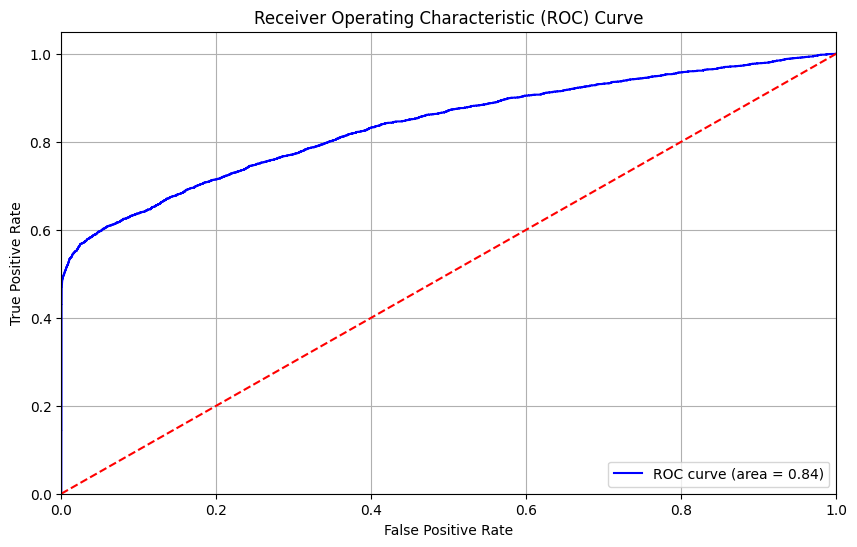

              precision    recall  f1-score   support

           0       0.89      0.99      0.94     14710
           1       0.96      0.51      0.66      3612

    accuracy                           0.90     18322
   macro avg       0.93      0.75      0.80     18322
weighted avg       0.91      0.90      0.89     18322

ROC-AUC: 0.8371904249977227


In [ ]:
if y_test.ndim == 2:
   y_test = y_test.flatten()
roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])

# Построение ROC-кривой
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Линия случайного угадывания
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Выводим отчёт
print(classification_report(y_test, y_pred))
print(f'ROC-AUC: {roc_auc}')

In [ ]:
import pandas as pd

# Пример данных
data = pd.DataFrame({
    'datetime': ['2023-04-20 20:37:30', '2023-04-21 15:22:10', '2023-04-22 09:45:00']
})

# Преобразование строк в datetime
data['datetime'] = pd.to_datetime(data['datetime'])

# Извлечение признаков из даты и времени
data['year'] = data['datetime'].dt.year
data['month'] = data['datetime'].dt.month
data['day'] = data['datetime'].dt.day
data['hour'] = data['datetime'].dt.hour
data['minute'] = data['datetime'].dt.minute
data['second'] = data['datetime'].dt.second
data['day_of_week'] = data['datetime'].dt.dayofweek

# Удаление оригинального столбца с датами
data.drop('datetime', axis=1, inplace=True)

print(data)

   year  month  day  hour  minute  second  day_of_week
0  2023      4   20    20      37      30            3
1  2023      4   21    15      22      10            4
2  2023      4   22     9      45       0            5


In [ ]:
pip install category-encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.2 MB/s eta 0:00:00
